### Import neccesary libraries


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

plt.style.use("default")

### Define the split type and stock name


In [34]:
split_type = [0.8,0.7,0.9]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [35]:
split = 2
stock = 1  # CMG

## 1.Data preprocessing


In [36]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,13590,13590,13360,13480,9850,CMG
1,2019-03-04,13550,14060,13550,13970,118020,CMG
2,2019-03-05,13830,14490,13830,14460,222050,CMG
3,2019-03-06,14460,14720,13850,14060,224770,CMG
4,2019-03-07,14340,14340,13830,13830,112670,CMG
...,...,...,...,...,...,...,...
1308,2024-05-27,60500,61100,57000,59000,2265500,CMG
1309,2024-05-28,59800,62400,59200,62100,1479800,CMG
1310,2024-05-29,62100,63400,60000,60000,2384000,CMG
1311,2024-05-30,59000,60100,58100,59200,1814100,CMG


<Axes: >

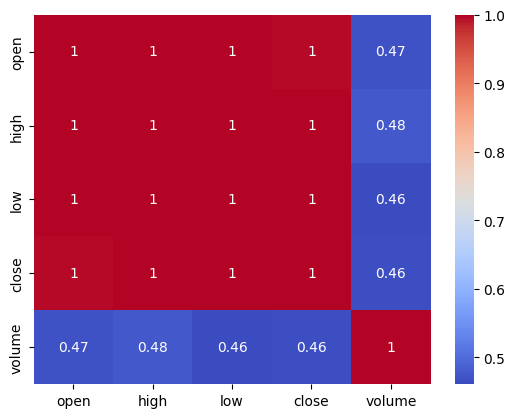

In [37]:
# Create a correlation matrix
df1 = df.drop(columns=["time", "ticker"], axis=1)
corr_matrix = df1.corr()

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#### Low price and close price are correlated => Good for forecast the "close price" in SARIMAX model

In [38]:
df = df[["low", "close"]] # Using low and close price to predict the next day close price, the low price is the exogenous variable

df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


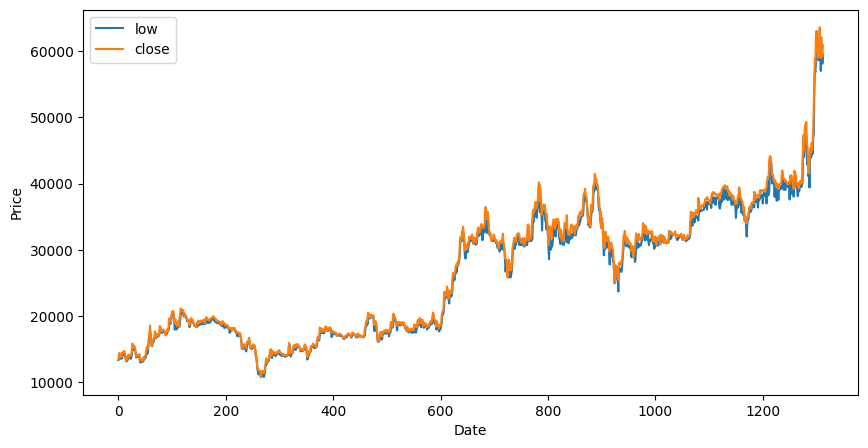

In [39]:
df.plot(figsize=(10, 5))
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

In [40]:
df.reset_index(drop=True)
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [41]:
# Shape of the dataframe
df.shape

(1313, 2)

In [42]:
df.dtypes

low      int64
close    int64
dtype: object

In [43]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,26235.587205,26832.390708
std,9802.115234,10097.555228
min,10780.000000,10880.000000
25%,17540.000000,17810.000000
50%,27510.000000,28380.000000
75%,33440.000000,34350.000000
max,63000.000000,63600.000000


## 2. Train model


In [44]:
# Defining the split size
train_size = int(split_type[split] * len(df))
test_size = len(df) - train_size

In [45]:
# splitting data into train, test set
train_data = df[:train_size]
test_data = df[train_size:]

In [46]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

In [47]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(0.9665029450963444,
 0.9938996357719839,
 21,
 1291,
 {'1%': -3.4354254066484664,
  '5%': -2.863781366113082,
  '10%': -2.56796331977745},
 20590.753479727184)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [48]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [49]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.378
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.341
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


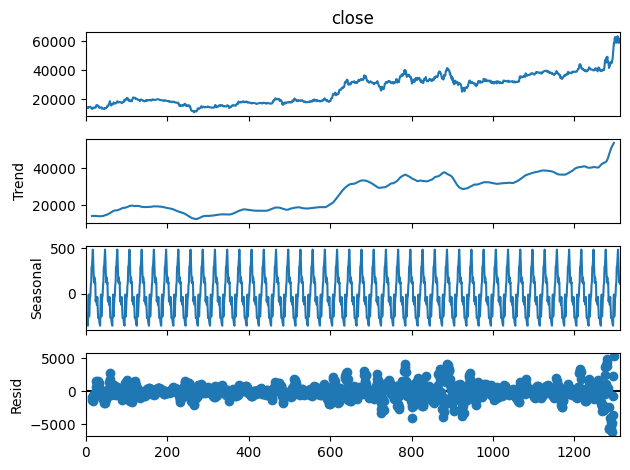

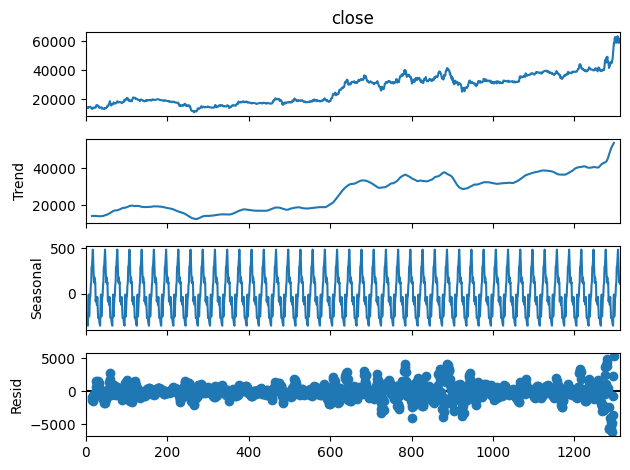

In [50]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [51]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [52]:
# Check again
adfuller(df_diff)

(-26.3312243027748,
 0.0,
 1,
 1178,
 {'1%': -3.435913333460925,
  '5%': -2.863996640985854,
  '10%': -2.5680779665111078},
 18136.833531324668)

The p-value is less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

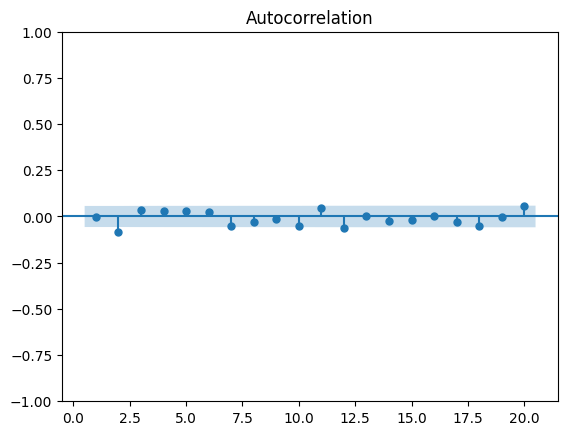

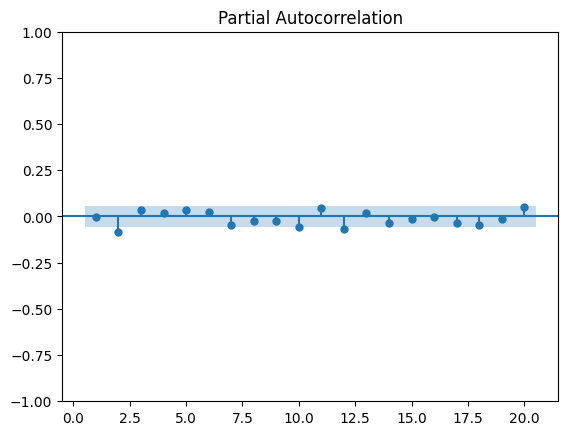

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [54]:
# Review the dataset again
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [55]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=18499.427, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=18501.740, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=18504.665, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=18504.550, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=18500.988, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=18502.340, Time=0.28 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=18502.577, Time=0.21 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=18502.403, Time=0.57 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=18502.818, Time=0.50 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=18502.083, Time=0.22 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=18500.919, Time=0.34 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=18500.464, Time=0.52 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=18500.301, Time=1.18 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=18502.124, Time=0.42 sec
 ARIMA(2,1,1)(1,0,1

In [56]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1181
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 5)   Log Likelihood               -9241.945
Date:                             Thu, 20 Jun 2024   AIC                          18497.891
Time:                                     06:53:28   BIC                          18533.404
Sample:                                          0   HQIC                         18511.279
                                            - 1181                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5164      0.059    -25.764      0.000      -1.632      -1.401
ar.L2         -0.8642      

#### Use SARIMAX to train model


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(2, 1, 2),
    seasonal_order=(1, 0, 1, 5),
)

model_fit = model1.fit()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Test


In [58]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([37238.35083767, 37241.64387394, 37315.90844842, 36846.86283581,
       38591.40926663, 37843.70569815, 37595.74170437, 37959.206428  ,
       38034.57863187, 38041.98458714, 36880.12233137, 37906.56079595,
       37860.56817952, 37891.40307201, 38515.62203915, 38210.57194062,
       38342.74673372, 38570.19658821, 38558.8967588 , 37416.1078691 ,
       38609.59442885, 38827.75098018, 38834.24831814, 38428.88789554,
       38564.33769305, 38741.44423339, 37420.40915673, 39669.24840972,
       40413.94121713, 38476.56276043, 38742.76204869, 39005.97179246,
       43149.07697047, 43233.45553488, 43146.87554618, 42530.37480173,
       40064.1332423 , 40813.69009664, 40812.28482399, 40327.85429434,
       40108.53885417, 38302.07546048, 39800.87221185, 39931.42232298,
       39623.82523142, 37773.81497139, 39756.14503094, 39139.68180322,
       37905.95844094, 39095.12456001, 39183.67491042, 39623.81489726,
       39360.10951573, 39359.40368962, 39447.86209956, 40372.72041477,
      

### Forecast the next 30/60/90 days


In [59]:
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [60]:
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [61]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Forecast closing prices for the next 30 days:")
print(y_30_days_pred)

Forecast closing prices for the next 30 days:
[39971.14192294 39993.33376617 40051.26028437 40015.14662176
 40051.98556092 40080.77335899 40098.36621482 40137.17032885
 40125.73074997 40152.03551219 40180.69776601 40195.35678787
 40229.92748905 40226.80589364 40253.27856109 40275.44982285
 40294.38518576 40320.50345198 40328.10242953 40349.41040198
 40372.55163444 40389.37659749 40414.77274241 40424.72583819
 40446.93620551 40466.75723662 40486.00333831 40507.3913669
 40522.19963748 40541.74746577]


### Plotting the data


In [65]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Next {days} days", linestyle="--"
    )
    plt.title(f"Forecast {stock_name[stock]} Stock Price Using SARIMAX")
    plt.legend()
    plt.show()

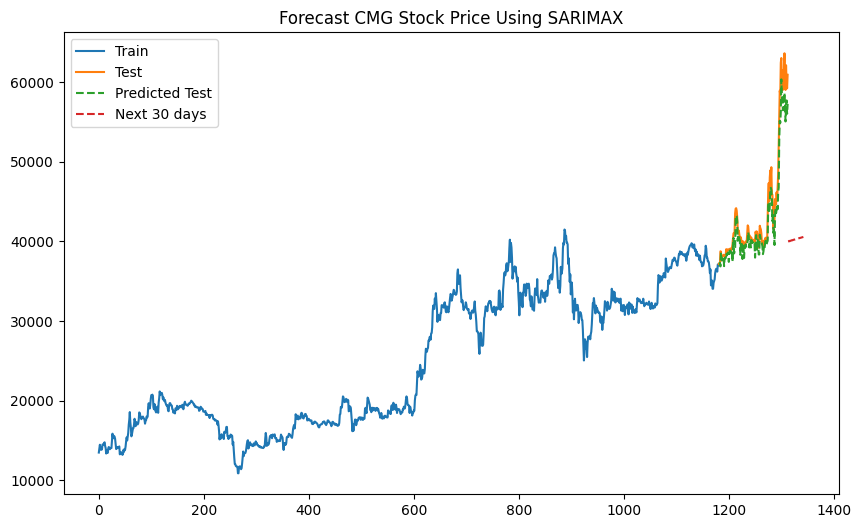

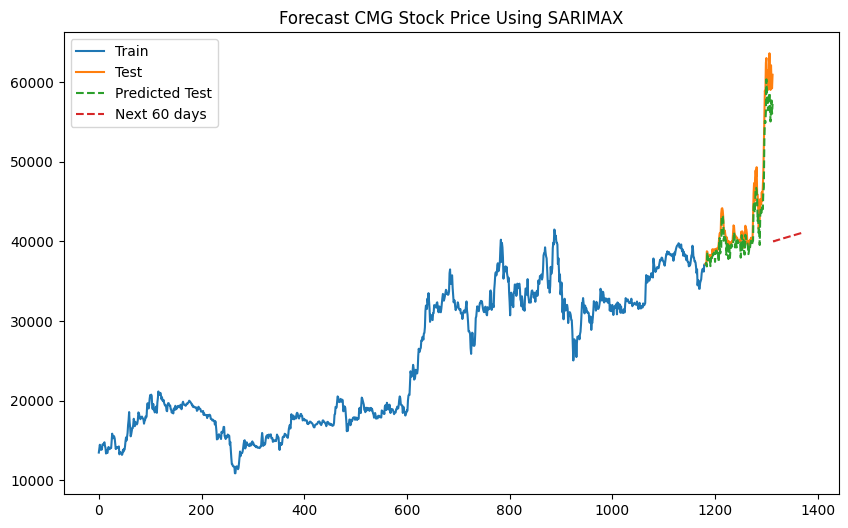

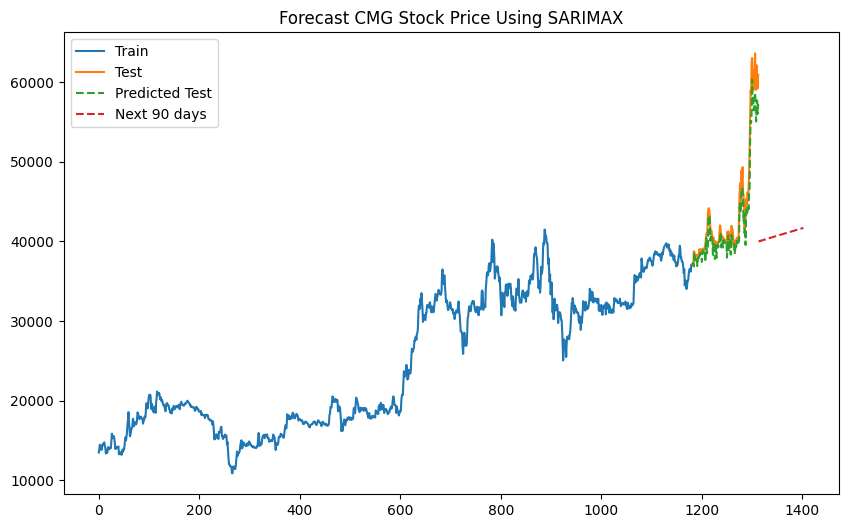

In [66]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [64]:
# Model evaluation on test set
print(f"RMSE: {rmse(y_test, y_pred_test)}")
print(f"MAE: {mae(y_test, y_pred_test)}")
print(f"MAPE: {mape(y_test, y_pred_test) * 100} %")

RMSE: 1880.0784278624067
MAE: 1333.98641583813
MAPE: 2.8036849761442912 %
